In [1]:
from train_shap import get_model_data_for_shap, ModelReversingY, get_data_for_Shap
import shap
import joblib
# beA3o82D_1112_1_all
fmodel, params, pp, fp= get_model_data_for_shap('trainshap_timeseries.yaml', 'beA3o82D', 1112)
joblib.dump(fmodel, 'fmodel.pkl')


/root/.conda/envs/nni/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-03 23:27:02.045 | INFO     | preprocessor:_dropna:156 - Dropping NaN values
2024-10-03 23:27:02.200 | INFO     | preprocessor:_dropna:180 - Columns with NaN values: Index(['Hematocrit_Avg_preclinical', 'Hematocrit_Avg_acute',
       'Hematocrit_Avg_chronic', 'LymphocytesPercentage_Avg_preclinical',
       'LymphocytesPercentage_Avg_acute', 'LymphocytesPercentage_Avg_chronic',
       'NeutrophilsPercentage_Avg_preclinical',
       'NeutrophilsPercentage_Avg_acute', 'NeutrophilsPercentage_Avg_chronic',
       'MonocytesPercentage_Avg_preclinical',
       ...
       'Crab_Avg_chronic', 'MixedGrasses_Avg_preclinical',
       'MixedGrasses_Avg_acute', 'MixedGrasses_Avg_chronic',
       'Mugwort_Avg_preclinical', 'Mugwort_Avg_acute'

[0]	train-rmsle:1.31736	train-roc_auc:0.65545	validation-rmsle:1.28875	validation-roc_auc:0.64356
[1]	train-rmsle:1.27584	train-roc_auc:0.65545	validation-rmsle:1.24816	validation-roc_auc:0.64356
[2]	train-rmsle:1.23590	train-roc_auc:0.71234	validation-rmsle:1.20933	validation-roc_auc:0.68676
[3]	train-rmsle:1.19762	train-roc_auc:0.73570	validation-rmsle:1.17174	validation-roc_auc:0.70681
[4]	train-rmsle:1.16091	train-roc_auc:0.75483	validation-rmsle:1.13576	validation-roc_auc:0.73033
[5]	train-rmsle:1.12592	train-roc_auc:0.74886	validation-rmsle:1.10156	validation-roc_auc:0.72412
[6]	train-rmsle:1.09249	train-roc_auc:0.75112	validation-rmsle:1.06918	validation-roc_auc:0.72564
[7]	train-rmsle:1.06067	train-roc_auc:0.75064	validation-rmsle:1.03857	validation-roc_auc:0.72575
[8]	train-rmsle:1.03052	train-roc_auc:0.74860	validation-rmsle:1.00966	validation-roc_auc:0.72384
[9]	train-rmsle:1.00212	train-roc_auc:0.74992	validation-rmsle:0.98271	validation-roc_auc:0.72410
[10]	train-rmsle:0.9

['fmodel.pkl']

In [17]:
X = get_data_for_Shap(fmodel, fp, params.copy(), 
                      0.5,
                      pp, k = 2.5, randomrate= 0.1,
                      pick_key= 'all')

model = ModelReversingY(fmodel, params)

if X.shape[0] > 100:
    X100 = shap.utils.sample(X, 100) 
else:
    X100 = X
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X100)

2024-10-03 23:33:58.942 | INFO     | preprocessor:_dropna:156 - Dropping NaN values
2024-10-03 23:33:59.081 | INFO     | preprocessor:_dropna:180 - Columns with NaN values: Index(['Hematocrit_Avg_preclinical', 'Hematocrit_Avg_acute',
       'Hematocrit_Avg_chronic', 'LymphocytesPercentage_Avg_preclinical',
       'LymphocytesPercentage_Avg_acute', 'LymphocytesPercentage_Avg_chronic',
       'NeutrophilsPercentage_Avg_preclinical',
       'NeutrophilsPercentage_Avg_acute', 'NeutrophilsPercentage_Avg_chronic',
       'MonocytesPercentage_Avg_preclinical',
       ...
       'Crab_Avg_chronic', 'MixedGrasses_Avg_preclinical',
       'MixedGrasses_Avg_acute', 'MixedGrasses_Avg_chronic',
       'Mugwort_Avg_preclinical', 'Mugwort_Avg_acute', 'Mugwort_Avg_chronic',
       'Salmon_Avg_preclinical', 'Salmon_Avg_acute', 'Salmon_Avg_chronic'],
      dtype='object', length=233)
2024-10-03 23:33:59.083 | INFO     | preprocessor:_imputation:192 - Imputing missing values
2024-10-03 23:33:59.664 | INF

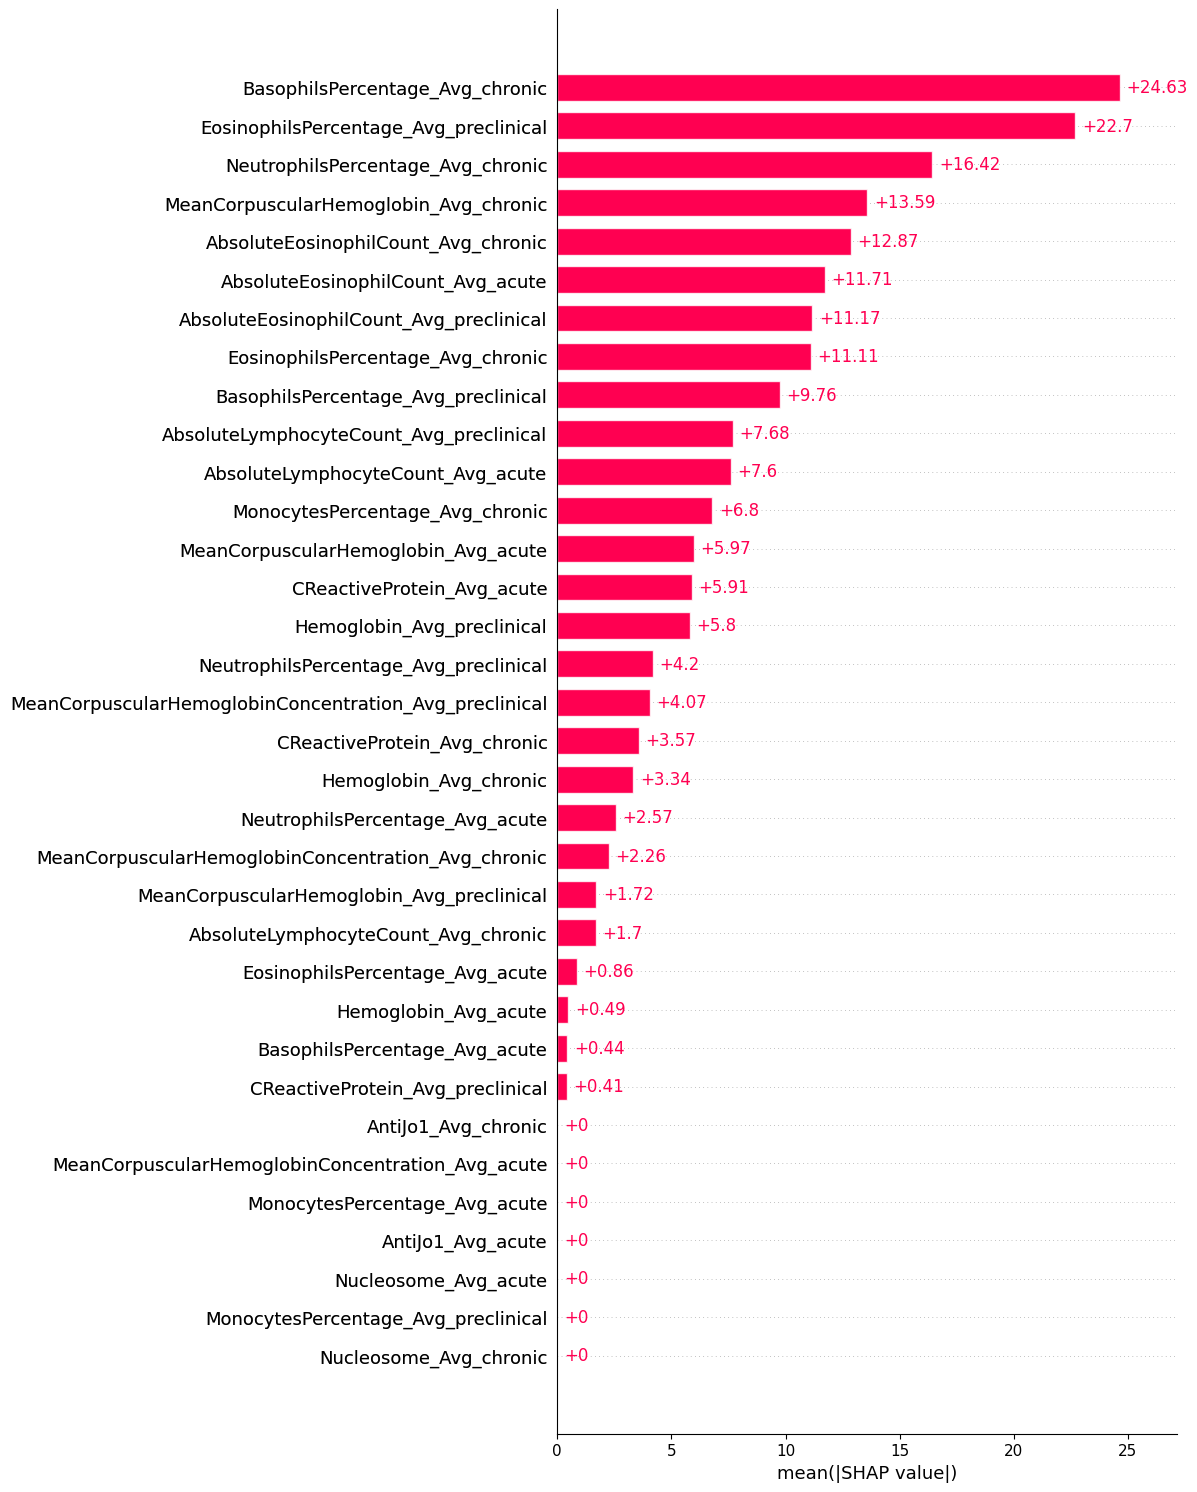

In [4]:
shap.plots.bar(shap_values, max_display=34)


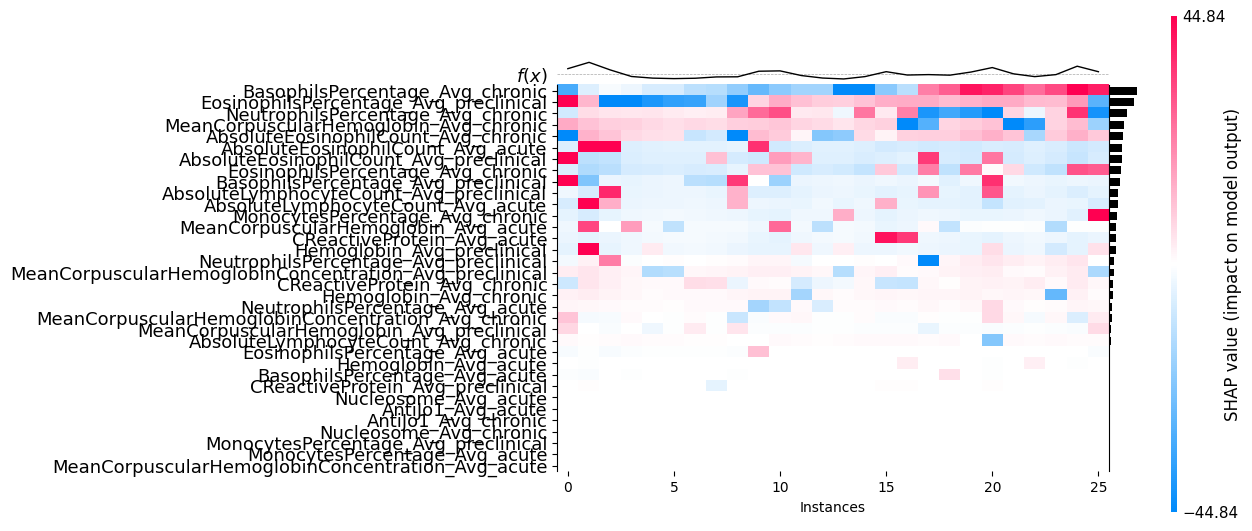

<Axes: xlabel='Instances'>

In [5]:
shap.plots.heatmap(shap_values[:1000], max_display=34)


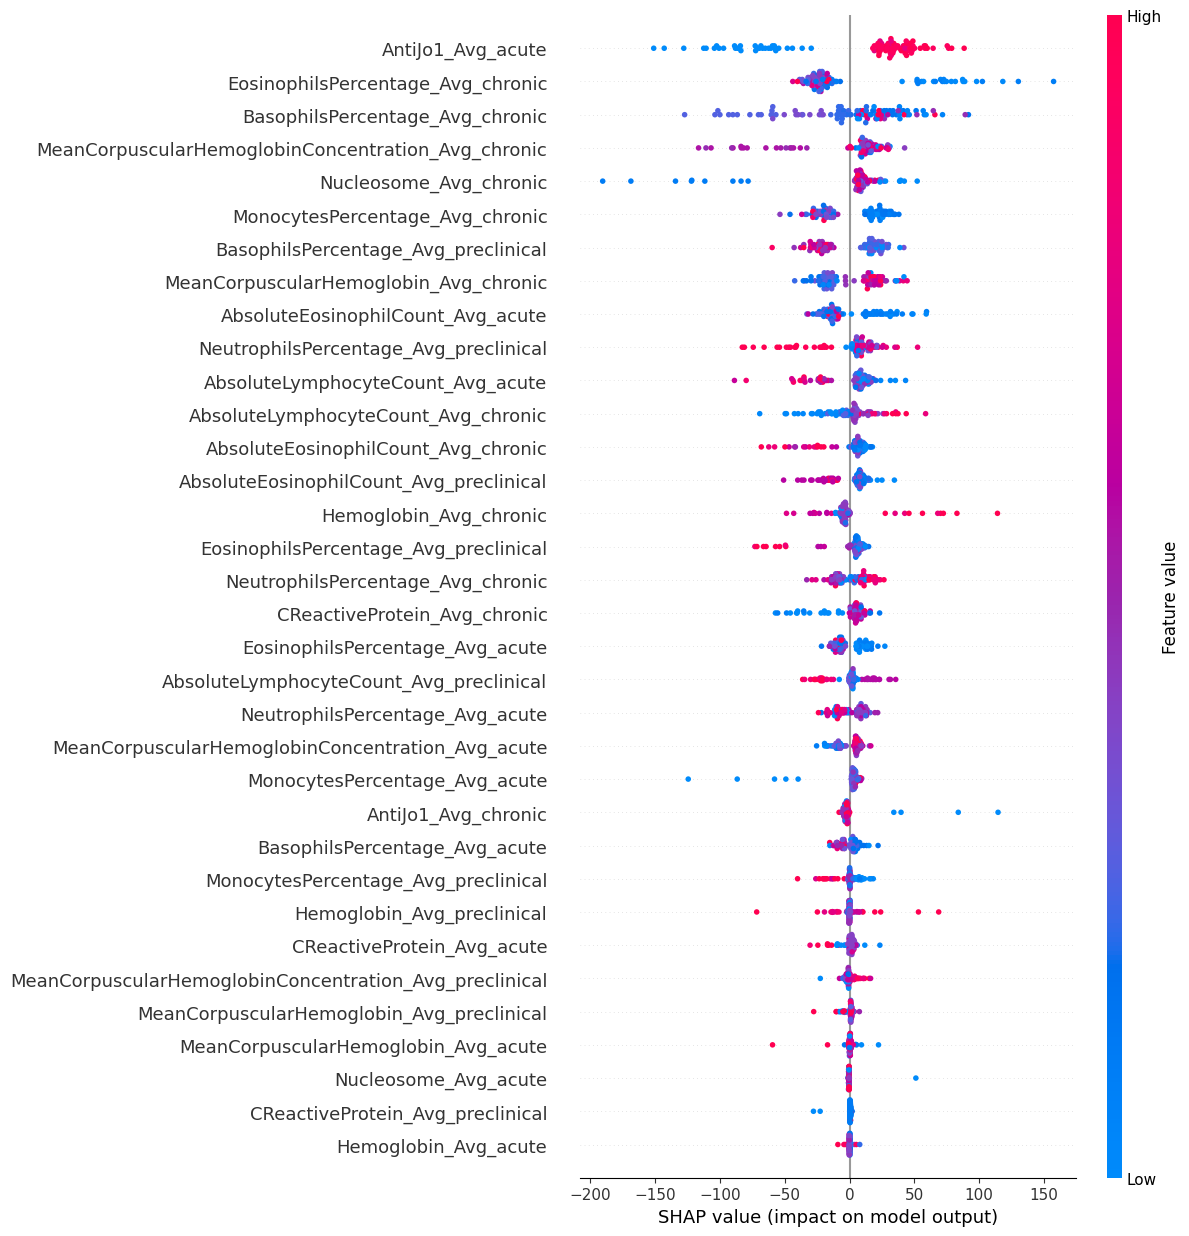

In [18]:
shap.plots.beeswarm(shap_values, max_display=34)
